In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


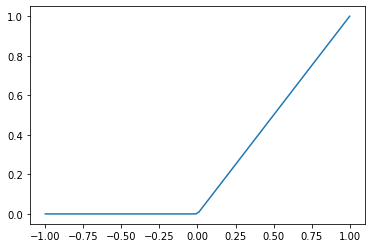

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.2
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.6,0.4]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.D

# Data

In [21]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator
from typing import *
from random import shuffle

class FixedBlockPassiveGenerator(AbsPassiveGenerator):
    def generate(self) -> Callable[..., Tensor]:
        i = np.random.randint(0,2)
        
        def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
            rad = torch.ones(list((lw/size).long()))*X0[self.materials[0]]
            if i == 1 and z == 0.6:
                rad[2:,2:] = X0[self.materials[1]]
            return rad
        
        return arb_rad_length, i

In [30]:
g,i = FixedBlockPassiveGenerator().generate()
g(z=0.8, lw=volume.lw, size=volume.passive_size),g(z=0.6, lw=volume.lw, size=volume.passive_size),i

(tensor([[0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528]]),
 tensor([[0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.3528, 0.3528, 0.3528],
         [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
         [0.3528, 0.3528, 0.1932, 0.1932, 0.1932],
         [0.3528, 0.3528, 0.1932, 0.1932, 0.1932]]),
 1)

In [23]:
from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:FixedBlockPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "pred_x0", "dpoca_x", "dpoca_y", "dpoca_z", "dpoca_r"],
                             'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [], 'row_wise': True}
        self.matrix_feats['feats_per_vec'] = len(self.matrix_feats['present_feats']), 
        self.matrix_feats['shape'] = (self.mu_bs, self.matrix_feats['feats_per_vec'])
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        return torch.tensor(bounds.reshape(3, -1).transpose(-1, -2), dtype=torch.float32) + (self.volume.passive_size/2)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            block, targ = self.passive_generator.generate()
            self.volume.load_rad_length(block)
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, pred[:,None], sb.location), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            data[:,:,-3:] -= self.voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
            data = torch.cat((data,torch.norm(data[:,:,-3:], dim=-1, keepdim=True)), dim=-1)  # dR
            
            # Sort by dR
            idxs = data[:,:,-1].argsort()
            i = np.arange(data.shape[0])[:,None]
            data = data[i,idxs]
            
            inputs.append(data[None,:])
            targets.append(targ)
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = np.array(targets)[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [24]:
sy = ScatterYielder(volume=volume, passive_generator=FixedBlockPassiveGenerator(materials=['beryllium', 'lead']), mu_bs=100, n_volumes_per_fold=160, targ_as_class=True)

In [25]:
sy.n_voxels

75

In [26]:
fold = sy[0]
fold['inputs'][1].shape,fold['targets'].shape

((160, 75, 100, 9), (160, 1))

In [27]:
fold['inputs'][1][0,0,:,-1]

array([0.1736922 , 0.19444694, 0.216574  , 0.3138869 , 0.34289628,
       0.34926528, 0.35809976, 0.36353874, 0.3837307 , 0.42051035,
       0.42578074, 0.43004858, 0.44976166, 0.45176384, 0.47343466,
       0.47583854, 0.50662583, 0.520541  , 0.5522926 , 0.55990595,
       0.5616303 , 0.5708585 , 0.57270586, 0.57412827, 0.5886771 ,
       0.61097014, 0.61849767, 0.62125146, 0.62766683, 0.63136935,
       0.63240033, 0.6402009 , 0.6442834 , 0.64872557, 0.6503081 ,
       0.6622145 , 0.66327995, 0.66671133, 0.6711052 , 0.6781651 ,
       0.67876756, 0.6859181 , 0.69016993, 0.6909582 , 0.6940234 ,
       0.6943201 , 0.6962557 , 0.6983794 , 0.700612  , 0.70206344,
       0.7049048 , 0.7069141 , 0.70851433, 0.71016216, 0.7157764 ,
       0.7162228 , 0.7299901 , 0.7363226 , 0.7430743 , 0.74834305,
       0.7505822 , 0.7541135 , 0.7575905 , 0.7646584 , 0.76647323,
       0.7673833 , 0.77604806, 0.77628225, 0.784294  , 0.7855996 ,
       0.80569446, 0.81550205, 0.8183493 , 0.82052916, 0.82401

In [28]:
fold['targets']

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
    

# Classifier

In [31]:
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsGraphFeatExtractor
from lumin.nn.models.blocks.gnn_blocks import *
from lumin.nn.models.initialisations import lookup_normal_init
from lumin.nn.models.layers.activations import lookup_act
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d, LCBatchNorm1d, RunningBatchNorm2d

from torch._vmap_internals import _vmap as vmap

class X0Net(AbsGraphFeatExtractor):
    row_wise:Optional[bool] = True
        
    def __init__(self, n_v:int, n_fpv:int, vox_centres:Tensor,
                 do:float=0, rep_bn:bool=False, act:str='relu',
                 lookup_init:Callable[[str,Optional[int],Optional[int]],Callable[[Tensor],None]]=lookup_normal_init,
                 lookup_act:Callable[[str],Any]=lookup_act, bn_class:Callable[[int],nn.Module]=nn.BatchNorm1d, rep_bn_class:Callable[[int],nn.Module]=nn.BatchNorm2d):
        super().__init__(n_v=n_v, n_fpv=n_fpv, do=do, bn=False, act=act, lookup_init=lookup_init, lookup_act=lookup_act, bn_class=bn_class)
        
        self.n_voxels,self.rep_bn,self.rep_bn_class = len(vox_centres),rep_bn,rep_bn_class
                
        # GNNs
        if self.rep_bn: self.init_bn = self.rep_bn_class(self.n_fpv)
        
        self.n_muon_rep, self.n_vox_rep = 40, 40
        self.muon_rep_gnn = GravNet(n_v=self.n_v, n_fpv=self.n_fpv,
                                    cat_means=True,
                                    f_slr_depth=3,
                                    n_s=4,
                                    n_lr=22,
                                    k=25,
                                    f_out_depth=1,
                                    n_out=[48],
                                    act=self.act,
                                    use_sa=False,
                                    bn=False,
                                   )
        self.muon_rep_collapser = GraphCollapser(n_v=self.n_v, n_fpv=self.muon_rep_gnn.get_out_size()[1],
                                                 flatten=False,
                                                 f_final_outs=[self.n_muon_rep],
                                                 n_sa_layers=0,
                                                 global_feat_vec=False,
                                                 act=self.act,
                                                 bn=False,
                                                )
        
        if self.rep_bn: self.muon_rep_bn = self.rep_bn_class(self.muon_rep_collapser.get_out_size()+4)
        
        self.vox_rep_gnn = GravNet(n_v=self.n_voxels, n_fpv=self.muon_rep_collapser.get_out_size()+4,
                                   cat_means=True,
                                   f_slr_depth=3,
                                   n_s=4,
                                   n_lr=22,
                                   k=12,
                                   f_out_depth=1,
                                   n_out=[48],
                                   act=self.act,
                                   use_sa=False,
                                   bn=False,
                                  )
        self.vox_rep_collapser = GraphCollapser(n_v=self.n_voxels, n_fpv=self.vox_rep_gnn.get_out_size()[1],
                                                flatten=False,
                                                f_final_outs=[self.n_vox_rep],
                                                n_sa_layers=0,
                                                global_feat_vec=False,
                                                act=self.act,
                                                bn=False,
                                               )
        
        # Relative voxel positions
        self.vox_centres = vox_centres  # (voxel,coords)
        vox_dists = self.vox_centres[None]-self.vox_centres[:,None]  # (voxel,voxel,coords)
        self.register_buffer('vox_dists', torch.cat((vox_dists,vox_dists.norm(dim=-1, keepdim=True)), dim=-1))
        
    def forward(self, x:Tensor) -> Tensor:
        r'''x=(volume,voxel,muon,feature)'''
        if self.rep_bn: x = self.init_bn(x.transpose(1,-1)).transpose(1,-1)
        
        def get_muon_rep(x:Tensor) -> Tensor:
            r'''(voxel,muon,feature)'''
            return self.muon_rep_collapser(self.muon_rep_gnn(x))
        
#         muon_rep = vmap(get_muon_rep)(x)  # (volume,voxel,muon_rep)
        muon_rep = torch.stack([get_muon_rep(v) for v in x.unbind()], dim=0)  # (volume,voxel,muon_rep)
        muon_rep = muon_rep[:,None].expand(-1,self.n_voxels, -1,-1)  # (volume,voxel,voxel,muon_rep)
        muon_rep = torch.cat((muon_rep, self.vox_dists[None].expand(len(muon_rep), -1, -1, -1)), dim=-1)
        if self.rep_bn: muon_rep = self.muon_rep_bn(muon_rep.transpose(1,-1)).transpose(1,-1)
        
        def get_vox_rep(x:Tensor) -> Tensor:
            r'''(voxel,voxel,muon_rep)'''
            return self.vox_rep_collapser(self.vox_rep_gnn(x))
        
#         vox_rep = vmap(get_vox_rep)(muon_rep)  # (volume,voxel,class)
        vox_rep = torch.stack([get_vox_rep(v) for v in muon_rep.unbind()], dim=0)  # (volume,voxel,class)
        return vox_rep
    
    def get_out_size(self) -> Tuple[int,int]: return self.n_voxels, self.n_vox_rep*2

In [32]:
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.optimisation.hyper_param import lr_find

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(X0Net, vox_centres=sy.voxel_centres, rep_bn=True, rep_bn_class=RunningBatchNorm2d, act='swish'),
               collapser=partial(GraphCollapser,
                                 flatten=True,
                                 f_final_outs=[10],
                                 bn=False,
                                 act='swish',
                                 bn_class=RunningBatchNorm1d
                                ))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('class', cont_feats=sy.matrix_feats['present_feats'], n_out=1,#len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head)
print(Model(model_builder))

Inputs:
9 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'pred_x0', 'dpoca_x', 'dpoca_y', 'dpoca_z', 'dpoca_r']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): X0Net(
      (init_bn): RunningBatchNorm2d()
      (muon_rep_gnn): GravNet(
        (grav_layers): ModuleList(
          (0): GravNetLayer(
            (f_slr): Sequential(
              (0): Sequential(
                (0): Linear(in_features=18, out_features=52, bias=True)
                (1): Swish()
              )
              (1): Sequential(
                (0): Linear(in_features=52, out_features=52, bias=True)
                (1): Swish()
              )
              (2): Sequential(
                (0): Linear(in_features=52, out_features=26, bias=True)
                (1): Swish()
              )
            )
            (f_out): Sequential(
              (0): Sequential(
 

In [33]:
sy.get_data_count(0)

160

LR finder took 123.642s 


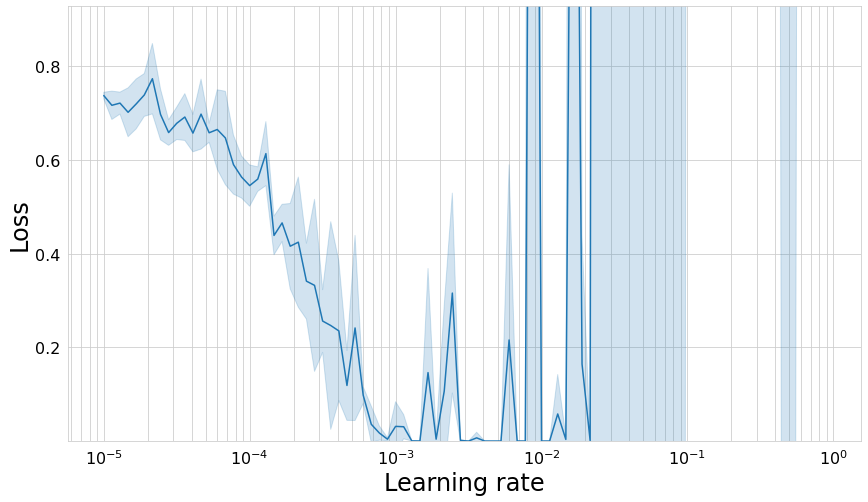

In [34]:
lr_finder = lr_find(sy, model_builder, bs=16, lr_bounds=[1e-5,1e0], n_repeats=3, bulk_move=False)

In [35]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import RocAucScore
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]
metric_partials = (RocAucScore)

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


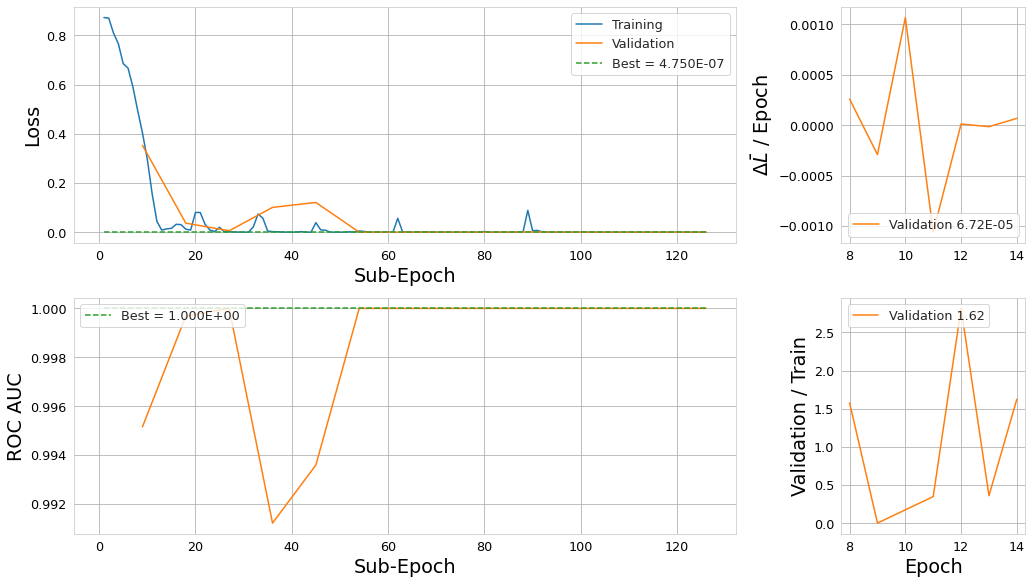

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe664a7f790> (for post_execute):


KeyboardInterrupt: 

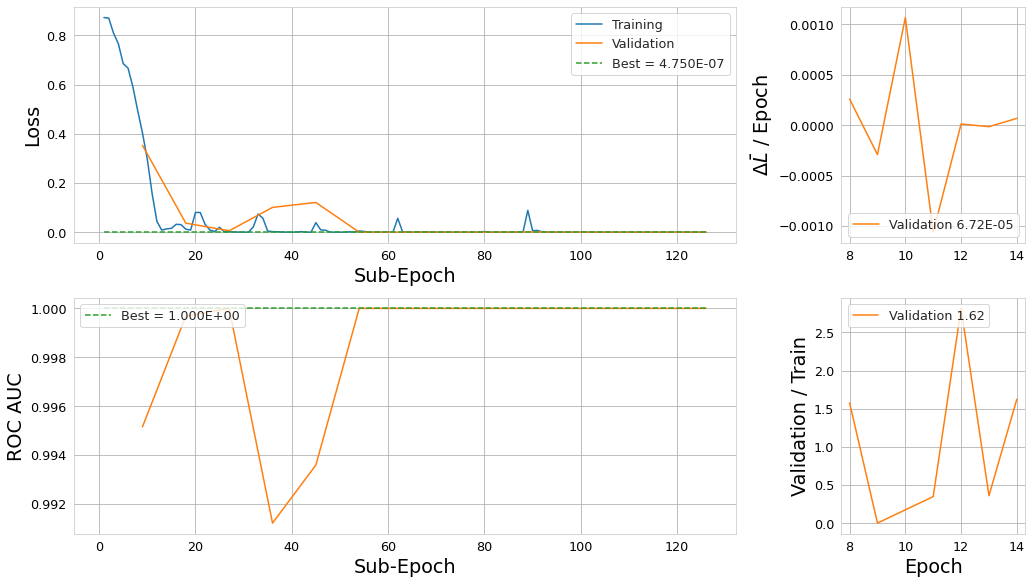

In [36]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=16,
                 cb_partials=cb_partials,
                 metric_partials=metric_partials,
                 n_epochs=15,
                 bulk_move=False)

In [37]:
model = Model.from_save('train_weights/model_id_0/best.h5', model_builder)

In [38]:
data = sy[0]

In [39]:
pred = model.predict(data['inputs'])

In [40]:
pred

array([[8.12020880e-06],
       [5.04851641e-06],
       [9.99986172e-01],
       [1.79235758e-05],
       [1.27748090e-05],
       [1.22547390e-05],
       [6.65329890e-06],
       [1.22975171e-05],
       [9.99926209e-01],
       [9.99896288e-01],
       [2.05136712e-06],
       [7.66144967e-06],
       [9.99985456e-01],
       [9.99967337e-01],
       [1.84692744e-05],
       [9.99939680e-01],
       [9.99679327e-01],
       [9.99994993e-01],
       [2.89262948e-06],
       [5.11317285e-06],
       [7.21216566e-06],
       [2.92252662e-06],
       [1.09728198e-05],
       [9.99965668e-01],
       [9.99962091e-01],
       [8.04751835e-06],
       [1.27737740e-05],
       [3.88011267e-06],
       [4.03347985e-05],
       [1.59838112e-06],
       [7.91438652e-06],
       [9.99999881e-01],
       [9.99968410e-01],
       [9.99737203e-01],
       [9.99941945e-01],
       [9.42718816e-06],
       [9.99334991e-01],
       [9.06362984e-05],
       [7.96770928e-06],
       [4.01267826e-05],


In [41]:
data['inputs'][1][0,0]

array([[ 3.25789675e-04,  8.25412571e-04,  1.16749121e-04,
        -4.59379262e-05,  3.76698875e+00,  6.56661987e-02,
         1.53369904e-02,  1.57440007e-01,  1.71273544e-01],
       [ 3.56473029e-05,  1.85131107e-03, -7.75511871e-05,
         1.49875007e-06,  8.64747167e-01,  8.57072771e-02,
         2.24852532e-01,  5.11257723e-02,  2.46004567e-01],
       [ 2.55809724e-03,  5.58325648e-03, -3.71571427e-04,
         1.69917970e-04,  8.06555673e-02,  7.04114139e-02,
         1.57280147e-01,  3.05798948e-01,  3.51009697e-01],
       [ 3.60539183e-04,  5.70465811e-03,  7.07121799e-05,
         4.46709828e-06,  9.06133130e-02,  1.97013259e-01,
         1.58581495e-01,  2.57543981e-01,  3.60958755e-01],
       [ 2.62965634e-03,  1.47785246e-03,  1.50566164e-04,
        -2.62489018e-04,  3.28892142e-01, -2.78728604e-02,
         2.47393996e-01,  2.81431645e-01,  3.75745207e-01],
       [ 9.62875783e-04,  1.80791318e-03, -2.21623894e-04,
         1.19400313e-04,  7.11931944e-01,  2.578336

In [42]:
# pred_class = pred.argmax(-1)
pred_class = pred > 0.5

In [43]:
pred_class

array([[False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [

In [44]:
targs = data['targets'].flatten()

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
confusion_matrix(targs, pred_class)

array([[80,  1],
       [ 0, 79]])

In [47]:
targs

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1])

In [48]:
from lumin.plotting.results import plot_roc, plot_binary_class_pred
from lumin.plotting.plot_settings import PlotSettings

In [49]:
import pandas as pd

In [50]:
df = pd.DataFrame({'pred':pred.squeeze(), 'gen_target':targs})

In [51]:
plot_settings = PlotSettings(targ2class={0:sy.passive_generator.materials[0], 1:sy.passive_generator.materials[1]})

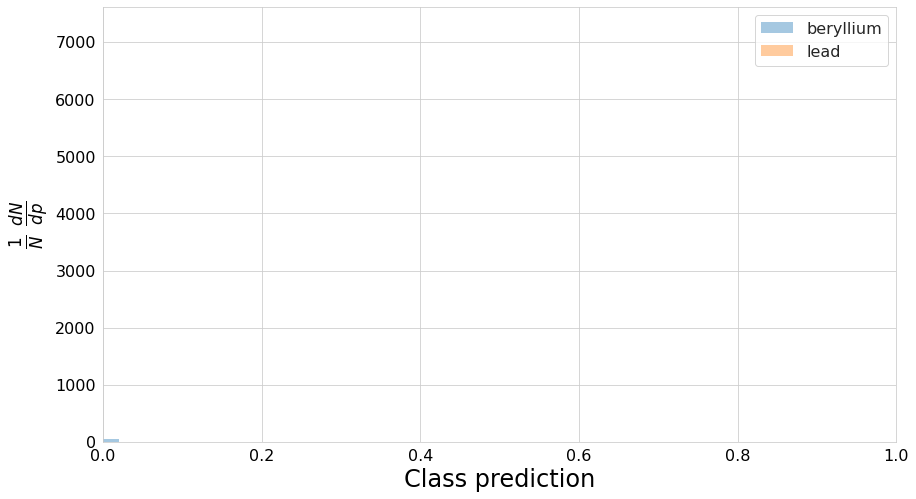

In [52]:
plot_binary_class_pred(df, settings=plot_settings)

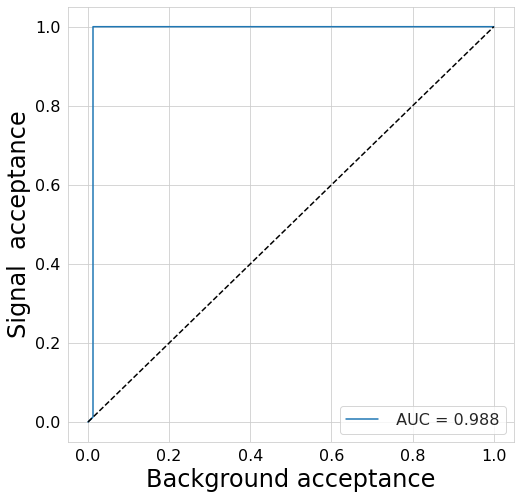

{'': 0.9877324581965932}

In [53]:
plot_roc(df)